# 06 - 2개의 층을 연결합니다.

# 06 - 01 - 신경망 알고리즘의 벡터화 

### 1. 점곱

#### 왜 np.sum이 아닌 dot함수를 사용하는가?
  - sum함수를 사용할 경우 반복문을 사용해서 전체 샘플을 돌려야 한다. -> 시간, 자원을 많이 소모한다.
  - dot함수를 사용한다면 모든 샘플에 대해 바로 계산을 할 수 있다. -> 시간, 자원 단축
  


In [51]:
import numpy as np
x = np.array([[1,2,3,4],
             [5,6,7,8]])
w = np.array([5,6,7,8])

# sum함수를 쓸 경우 for문 사용
sumXW = []
for i in range(len(x)):
    sumXW.append(np.sum(x[i] * w))

# dot함수를 쓸 경우 for사용 X
dotXW = np.dot(x, w)

# 결과
print('sumXW = ', sumXW, 'dotXW = ', dotXW)

sumXW =  [70, 174] dotXW =  [ 70 174]


### cancer 데이터셋의 정방향 계산

In [52]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 데이터 나누기 (훈련 세트, 테스트 세트)
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 데이터 나누기 (훈련 세트, 테스트 세트)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 확인하기
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [53]:
def forpass(self, x):
    # 이전의 코드
    z = np.sum(x * self.w) + self.b
    return z

def forpass(self, x):
    # 배치 경사 하강법을 위한 코드 (전체 데이터를 한번에 계산하는 방법)
    z = np.dot(x, self.w) + self.b
    return z

### cancer 데이터셋의 역방향 계산

In [54]:
def backprop(self, x, err):
    # 이전의 코드
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

def backprop(self, x, err):
    m = len(x) # 전체 샘플의 수, 각각의 그레이디언트는 전체 샘플의 수로 나눈다.


    # x : (샘플 수, 속성수), err : (샘플 수,) -> 점곱이 불가능하다.
    # x.T로 전치하여 계산
    # w_grad의 각 행은 각 특성에 따른 err이 곱해진 그레이디언트가 계산된다.
    # g1 = x1*e1 + x2*e2 + x3*e3 ... xn*en
    w_grad = np.dot(x.T, err) / m

    b_grad = np.sum(err) / m
    return w_grad, b_grad

### fit 메서드 수정
``` python
# 이전의 코드
for i in range(epochs):
    loss = 0
    indexes = np.random.permutation(np.arrange(len(x)))
    for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)

# 이후의 코드
for i in range(epochs):
    z = self.forpass(x)      # 전체 샘플 정방향 계산
    a = self.activation(z)   # 전체 샘플 활성화 함수 계산
    err = -(y - a)           # 전체 샘플의 오차 계산

```

In [55]:
import numpy as np
def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    y = y.reshape(-1, 1)                # 타깃을 열 벡터로 바꿉니다.
    y_val = y_val.reshape(-1, 1)        # 검증용 타깃을 열 벡터로 바꿉니다.
    m = len(x)                          # 샘플의 개수를 저장합니다.
    self.w = np.ones((x.shape[1], 1))   # 가중치를 초기화 합니다.
    self.b = 0                          # 절편을 초기화 합니다.
    self.w_history.append(self.w.copy())# 가중치를 기록합니다.

    # epochs만큼 반복합니다.
    for i in range(epochs):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)

        # 오차를 역전파하여 그레이디언트를 계산합니다.
        w_grad, b_grad = self.backprop(x, err)

        # 그레이디언트에서 페널티 항의 미분값을 더합니다.
        w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m

        # 가중치와 절편을 업데이트 합니다.
        self.w -= self.lr * w_grad
        self.b -= self.lr * b_grad

        # 가중치를 기록합니다.
        self.w_history.append(self.w.copy())

        # 안전한 로그 계산을 위해 클리핑합니다.
        a = np.clip(a, 1e-10, 1-1e-10)

        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
        self.losses.append((loss + self.reg_loss()) / m)

        # 검증 세트에 대한 손실을 계산합니다.
        self.update_val_loss(x_val, y_val)


### 나머지 메서드 수정하기

In [56]:
import numpy as np
def predict(self, x):
    z = self.forpass(x)
    return z > 0

def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.activation(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
    val_loss = np.sum(-(y_val * np.log(a) + (1-y_val)*np.log(1-a)))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

## 배치 하강법을 위한 단일층 신경망

In [57]:
import numpy as np
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None                       # 가중치
        self.b = None                       # 절편
        self.losses = []                    # 훈련 손실
        self.val_losses = []                # 검증 손실
        self.w_history = []                 # 가중치 기록
        self.lr = learning_rate             # 학습률
        self.l1 = l1                        # L1 규제 하이퍼 파라미터 적용
        self.l2 = l2                        # L2 규제 하이퍼 파라미터 적용
    
    def forpass(self, x):
        # 배치 경사 하강법을 위한 코드 (전체 데이터를 한번에 계산하는 방법)
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err):
        m = len(x) # 전체 샘플의 수, 각각의 그레이디언트는 전체 샘플의 수로 나눈다.

        # x : (샘플 수, 속성수), err : (샘플 수,) -> 점곱이 불가능하다.
        # x.T로 전치하여 계산
        # w_grad의 각 행은 각 특성에 따른 err이 곱해진 그레이디언트가 계산된다.
        # g1 = x1*e1 + x2*e2 + x3*e3 ... xn*en
        w_grad = np.dot(x.T, err) / m

        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                # 타깃을 열 벡터로 바꿉니다.
        y_val = y_val.reshape(-1, 1)        # 검증용 타깃을 열 벡터로 바꿉니다.
        m = len(x)                          # 샘플의 개수를 저장합니다.
        self.w = np.ones((x.shape[1], 1))   # 가중치를 초기화 합니다.
        self.b = 0                          # 절편을 초기화 합니다.
        self.w_history.append(self.w.copy())# 가중치를 기록합니다.

        # epochs만큼 반복합니다.
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)

            # 오차를 역전파하여 그레이디언트를 계산합니다.
            w_grad, b_grad = self.backprop(x, err)

            # 그레이디언트에서 페널티 항의 미분값을 더합니다.
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m

            # 가중치와 절편을 업데이트 합니다.
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad

            # 가중치를 기록합니다.
            self.w_history.append(self.w.copy())

            # 안전한 로그 계산을 위해 클리핑합니다.
            a = np.clip(a, 1e-10, 1-1e-10)

            # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)

            # 검증 세트에 대한 손실을 계산합니다.
            self.update_val_loss(x_val, y_val)
    
    def activation(self, z):
        z = np.clip(z, -100, None)          # 안전한 np.exp() 계산을 위한 clip함수
        a = 1 / (1 + np.exp(-z))            # 시그모이드 계산
        return a
    
    def predict(self, x):
        z = self.forpass(x)                 # 정방향 계산
        return z > 0                        # 예측 결과 반환


    def score(self, x, y):                      # 성능을 보여주는 메서드
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))

    # 로지스틱 손실 함수 계산에 페널티 항 추가하기
    def reg_loss(self):
        # 가중치에 규제를 적용합니다.
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    
    # 검증 손실을 업데이트 합니다.
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)             # 정방향 계산 수행
        a = self.activation(z)              # 활성화 함수 적용
        a = np.clip(a, 1e-10, 1-1e-10)      # 출력값을 클리핑
        # 로그 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-(y_val * np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [58]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
# 데이터 불러오기
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target

# 훈련 세트와 테스트 세트 나누기
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

# 훈련 세트로부터 검증 세트 나누기
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

# 데이터 전처리하기 (표준화)
# StandardScaler로도 가능하다
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [59]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train,
                 x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

## 검증 세트로 성능 측정하고 그래프 비교하기

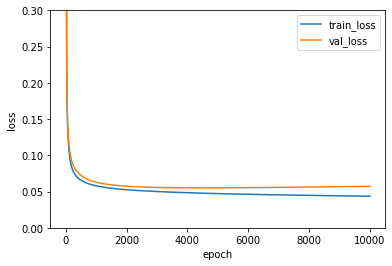

In [60]:
import matplotlib.pyplot as plt
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### 앞의 확률적 경사하강법을 사용한 것보다 부드러운 곡선이 되었다.
- 왜 그런가? 다음 그래프를 살펴보자

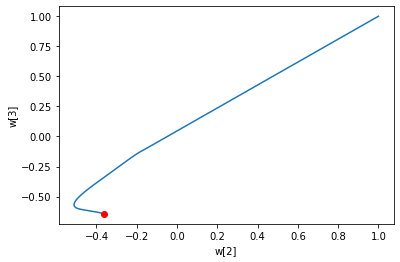

In [61]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

# 결론
- 배치하강법은 전체 샘플을 사용하여 가중치를 업데이트하기 때문에 손실값이 안정적으로 감소한다.
- 그렇기에 가중치를 찾는 경로가 다소 부드러운 곡선을 띈다.